In [5]:
!pip install scipy
!pip install ruptures


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# imports

In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt


# Dataset loading

In [54]:
filepath = './datasets/basic_motions/BasicMotions_TRAIN.arff'

def load_dataset_to_dataframe(path):
    """Load data that is stored within the path

    Args:
        path: string with path containing data
    Returns:
        A pandas dataframe with only data inside
    """
    dataset = arff.loadarff(path)
    df = pd.DataFrame(dataset[0])
    return df 

df = load_dataset_to_dataframe(filepath)


# Clear segementation off dataset and custom change point detection 

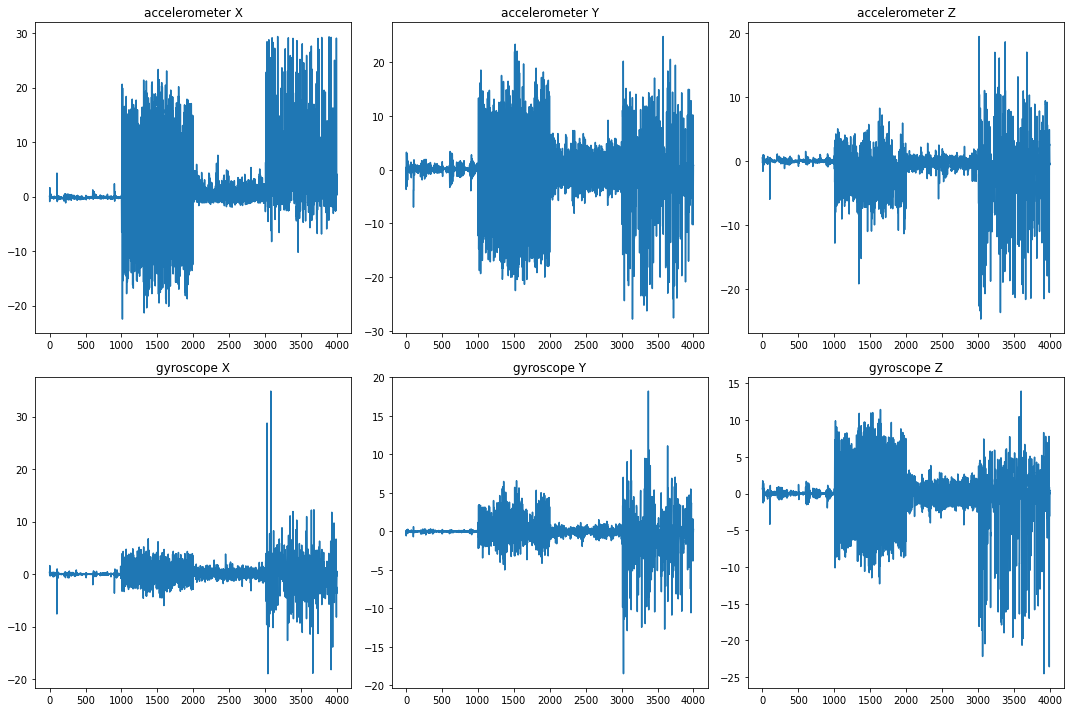

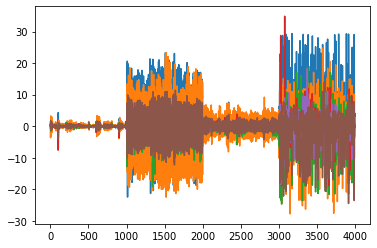

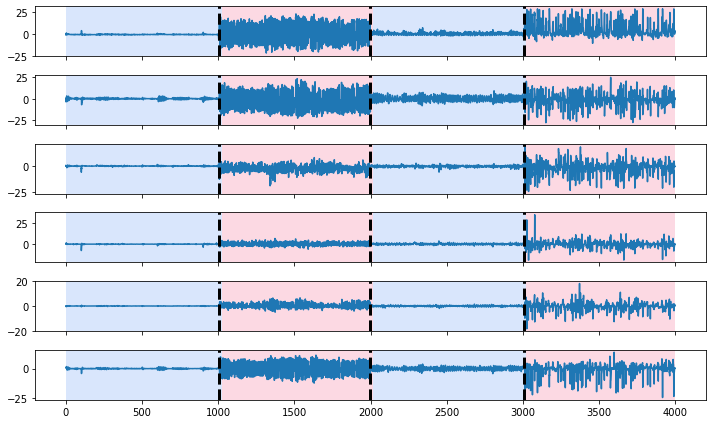

In [53]:
def stack_time_series(df):
    """This function creates new dataframe without segmentation and classification

    Args:
        df: segmented dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
    """
    dimensionality = df.iloc[0,0].shape[0] # assumption that data dimensionality is the number of rows of first element in dataframe
    # also the first column is expected to store data (second stores classification)
    
    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))
    
    # filling it with empty numpy arrays
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])
    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        for r in row[0]:
             stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
             i += 1
    return stacked

def dataframe_to_ndarray(df):
    """This function creates ndarray(2 dmiensional, shape: length x dim) of dataframe (shape: dim x length)

    Args:
        df: dataframe
    Returns:
        A numpy array with shape: length x dim)
    """
    ndarray = np.array([])
    for index, row in df.iterrows():
        if index == 0:
            ndarray = row[0]
        else:
            ndarray = np.vstack((ndarray,row[0]))
    return ndarray.transpose()


stacked = stack_time_series(df)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot different data on each subplot
axs[0, 0].plot(stacked.iloc[0,0])
axs[0, 0].set_title('accelerometer X')

axs[0, 1].plot(stacked.iloc[1,0])
axs[0, 1].set_title('accelerometer Y')

axs[0, 2].plot(stacked.iloc[2,0])
axs[0, 2].set_title('accelerometer Z')

axs[1, 0].plot(stacked.iloc[3,0])
axs[1, 0].set_title('gyroscope X')

axs[1, 1].plot(stacked.iloc[4,0])
axs[1, 1].set_title('gyroscope Y')

axs[1, 2].plot(stacked.iloc[5,0])
axs[1, 2].set_title('gyroscope Z')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

n, dim = 4000, 6  # number of samples, dimension
n_bkps, sigma = 3, 5  # number of change points, noise standart deviation
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)
# print((signal))
# print((signal).shape)

# plt.plot(signal)
# plt.show()

motion_basics_stacked_ndarray = dataframe_to_ndarray(stacked)

plt.plot(motion_basics_stacked_ndarray)
plt.show()

# change point detection
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Window(model=model).fit(motion_basics_stacked_ndarray)

my_bkps = algo.predict(n_bkps=3)

rpt.show.display(motion_basics_stacked_ndarray, bkps, my_bkps, figsize=(10, 6))
plt.show()

# Evaluation 

In [50]:
# https://ceur-ws.org/Vol-1226/paper31.pdf

def points_labels_vector(n,change_points):
    """This function creates vector of predicated labels [0,0, ...,1,...0] 
    where 1 means time series at this index is change point, and 0 that there is no change point

    Args:
        n: count of time series
        change_points: 1-D numpy array with change point indexes
    Returns:
        A 1-D numpy array with lenght of n, containing ones and zeros
    """
    predicted_labels = np.zeros(n)
    predicted_labels[change_points] = 1
    return predicted_labels


def calculate_TP_TN_FP_FN(n, predicted_points, original_points, treshold):
    """This function calculates TP, TN, FP, FN , the change point is correct if its distance from original
    change point is closer then treshold, when there is more than one change point within the threshold the additional
    ones are considered FP

    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        A scalar values of TP, TN, FP, FN
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    TP = 0
    TN = 0
    FP = 0
    FN = 0
    zone_counter = np.zeros(len(predicted_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                which_point = np.argmin(np.abs(original_points - index))
                if zone_counter[which_point] == True :
                    FP+=1
                else:
                    TP+=1     
                    zone_counter[which_point] = True
        else:
            if value == 0:
                TN+=1
            else:
                FP+=1

    for index , val in enumerate(zone_counter):
         if val == False:
             FN+=1

    return TP, TN, FP, FN
            


def calculate_ACC_PRE_REC(TP,TN,FP,FN):
    A = (TP+TN)/(TP+TN+FP+FN)
    P = TP/(TP+FP)
    R = TP/(TP+FN)
    return A,P,R
    

[1005, 2000, 3005, 4000]
4000


In [51]:
TP,TN,FP,FN = calculate_TP_TN_FP_FN(4000,my_bkps[:-1],np.array([1000,2000,3000]),3)


print(TP)
print(TN)
print(FP)
print(FN)

Acc, Prec, Recall = calculate_ACC_PRE_REC(TP,TN,FP,FN)

print(Acc)
print(Prec)
print(Recall)

1
3983
2
2
0.9989969909729187
0.3333333333333333
0.3333333333333333


In [75]:
def stack_time_series_randomly(df):
    """This function creates new dataframe without segmentation and classification

    Args:
        df: segmented dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
        , numpy array containing change points
    """
    dimensionality = df.iloc[0,0].shape[0] # assumption that data dimensionality is the number of rows of first element in dataframe
    # also the first column is expected to store data (second stores classification)

    change_points = np.array([])
    
    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))

    # randomize rows
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    # filling it with empty numpy arrays
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])

    print(df)
    last_class = df.iloc[0,1]

    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        if last_class != row[1]:
            change_points = np.append(change_points,index*100)
        last_class = row[1]
        for r in row[0]:
             stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
             i += 1
    return stacked, change_points

random_stacked, change_points = stack_time_series_randomly(df))
print(random_stacked)
print(change_points)


plt.plot(random_stacked)
plt.show()
# shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# print("\nPomieszany DataFrame:")
# print(shuffled_df)

                                        relationalAtt      activity
0   [[2.508158, 2.508158, 2.121694, 0.212363, -2.8...    b'Running'
1   [[1.370472, 1.370472, 8.988115, 9.96166, 14.36...    b'Running'
2   [[-0.359319, -0.359319, 4.011746, 3.969688, 3....    b'Running'
3   [[-0.761604, -0.761604, 0.121078, -0.548465, -...    b'Walking'
4   [[-0.123238, -0.123238, -0.249547, -0.272929, ...   b'Standing'
5   [[2.221946, 2.221946, -7.704172, -10.204578, 2...    b'Running'
6   [[1.142016, 1.142016, 0.840727, -0.013852, -0....  b'Badminton'
7   [[-0.255266, -0.255266, -0.792226, 0.490267, 1...    b'Walking'
8   [[1.211973, 1.211973, -0.605948, 0.476761, 2.5...  b'Badminton'
9   [[1.236069, 1.236069, 0.118106, -0.311451, 0.8...   b'Standing'
10  [[-0.185181, -0.185181, -1.319727, -0.921034, ...    b'Walking'
11  [[-0.407421, -0.407421, 2.355158, 1.147434, 0....   b'Standing'
12  [[1.463566, 1.463566, 6.169349, 12.296801, 11....    b'Running'
13  [[0.130669, 0.130669, 0.068821, 1.076776, 1.

AttributeError: 'tuple' object has no attribute 'iterrows'